# CAP FINAL PROJECT A

## 1. Data Preprocessing

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, atan2
import folium
import geopandas as gpd
import matplotlib.pyplot as plt

### Loading dataset

In [27]:
df_test = pd.read_csv('new-york-city-taxi-fare-prediction/test.csv' )
df_train = pd.read_csv('new-york-city-taxi-fare-prediction/train.csv', nrows=10000)
df = pd.concat([df_train, df_test], axis=0)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Clean Data - Remove Outliers

In [28]:
# Filter unrealistic fare amounts
df = df[df['fare_amount'] >= 2]

# Define NYC latitude and longitude boundaries
nyc_min_longitude, nyc_max_longitude = -74.05, -73.75
nyc_min_latitude, nyc_max_latitude = 40.63, 40.85

# Filter out coordinates outside NYC boundaries
df = df[
    (df['pickup_longitude'].between(nyc_min_longitude, nyc_max_longitude)) &
    (df['pickup_latitude'].between(nyc_min_latitude, nyc_max_latitude)) &
    (df['dropoff_longitude'].between(nyc_min_longitude, nyc_max_longitude)) &
    (df['dropoff_latitude'].between(nyc_min_latitude, nyc_max_latitude))
]

### Extract Time-based Features

In [29]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month 
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,month
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,6
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,8
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,3


### Calculate Distance using Haversine Formula

In [30]:
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply vectorized function
df['distance_km'] = haversine_vectorized(
    df['pickup_latitude'].values, df['pickup_longitude'].values,
    df['dropoff_latitude'].values, df['dropoff_longitude'].values
)
df['distance_km']

0       1.030764
1       8.450134
2       1.389525
3       2.799270
4       1.999157
          ...   
9995    3.464212
9996    1.166274
9997    4.059500
9998    1.493453
9999    5.026301
Name: distance_km, Length: 9648, dtype: float64

### Perform Geographical Clustering

In [31]:
# Pickup clusters
coords = df[['pickup_latitude', 'pickup_longitude']].values
kmeans = KMeans(n_clusters=10, random_state=42)
df['pickup_cluster'] = kmeans.fit_predict(coords)

# Drop-off clusters
coords = df[['dropoff_latitude', 'dropoff_longitude']].values
df['dropoff_cluster'] = kmeans.fit_predict(coords)

# 8. Add Time-based Features (e.g., Peak Hours)
def is_peak_hour(hour):
    return 1 if 7 <= hour <= 9 or 16 <= hour <= 19 else 0

df['is_peak_hour'] = df['hour'].apply(is_peak_hour)

### Normalize Numerical Features

In [32]:
scaler = StandardScaler()
df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = scaler.fit_transform(
        df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,month,distance_km,pickup_cluster,dropoff_cluster,is_peak_hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,3.933651,-1.119256,4.192034,-1.406817,1,17,15,0,6,-0.647287,5,7,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-1.209015,-1.495037,-0.149399,1.085226,1,16,5,1,1,1.575745,6,3,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-0.211547,0.379629,-0.527033,-0.038527,2,0,18,3,8,-0.539793,7,1,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-0.343065,-0.675642,-0.537282,0.230599,1,4,21,5,4,-0.117398,4,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,0.226938,0.632426,0.563766,1.148058,1,7,9,1,3,-0.357132,7,3,1


<h1>2. Exploratory Data Analysis</h1>

### Univariate Analysis

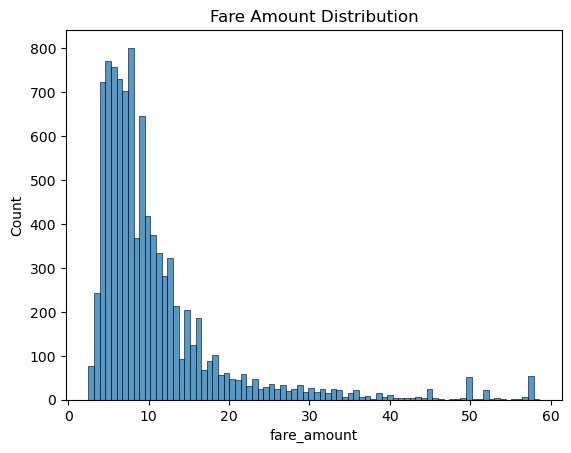

In [33]:
sns.histplot(df['fare_amount'], bins=80)
plt.title("Fare Amount Distribution")
max_fare = df['fare_amount'].max()
plt.show()

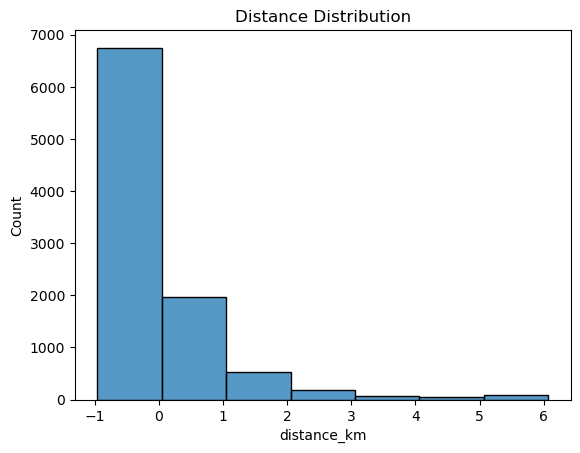

In [34]:
sns.histplot(df['distance_km'], bins=7)
plt.title("Distance Distribution")
plt.show()

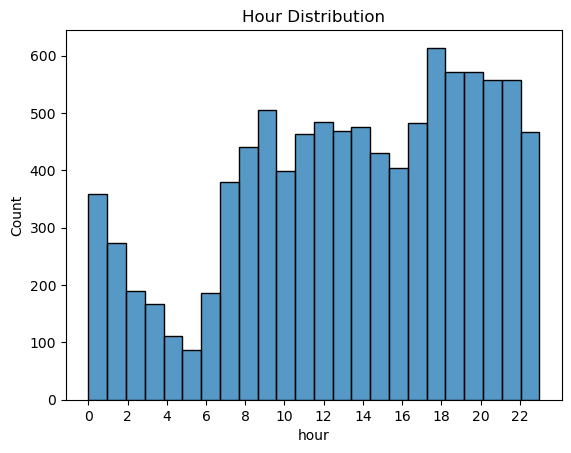

In [35]:
sns.histplot(df['hour'], bins=24)
plt.xticks(np.arange(0, 24, 2))
plt.title("Hour Distribution")
plt.show()

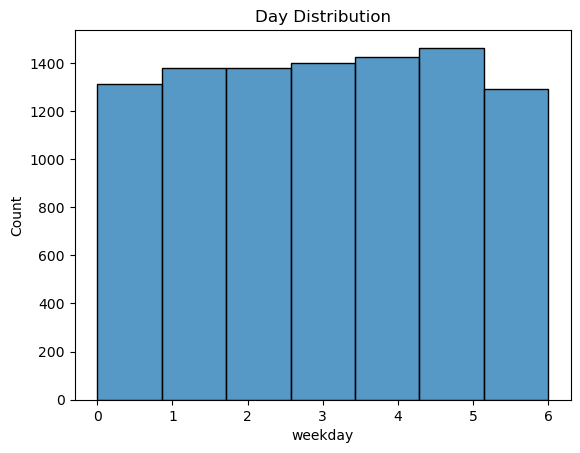

In [36]:
sns.histplot(df['weekday'], bins=7)
plt.title("Day Distribution")
plt.show()

### Bivariate Analysis

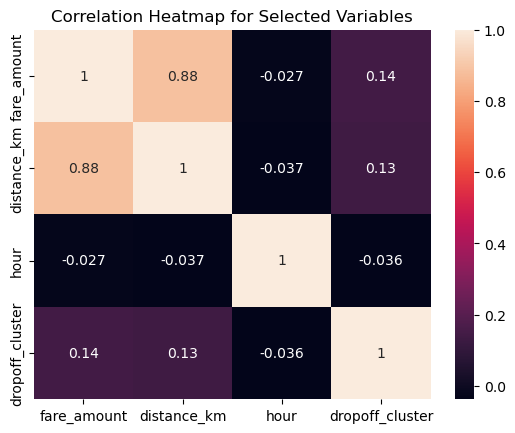

In [37]:
corr = df[['fare_amount', 'distance_km', 'hour', 'dropoff_cluster']].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap for Selected Variables")
plt.show()

### Geospatial Analysis

In [38]:
# Invert the scaling so it plots properly on nyc map
df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']] = scaler.inverse_transform(
        df[['distance_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [39]:
# Create GeoDataFrame for pickups and dropoffs
pickup_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['pickup_longitude'], df['pickup_latitude']))
dropoff_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['dropoff_longitude'], df['dropoff_latitude']))

# Load the NYC shapefile
nyc_boundary = gpd.read_file('nyc.shp')

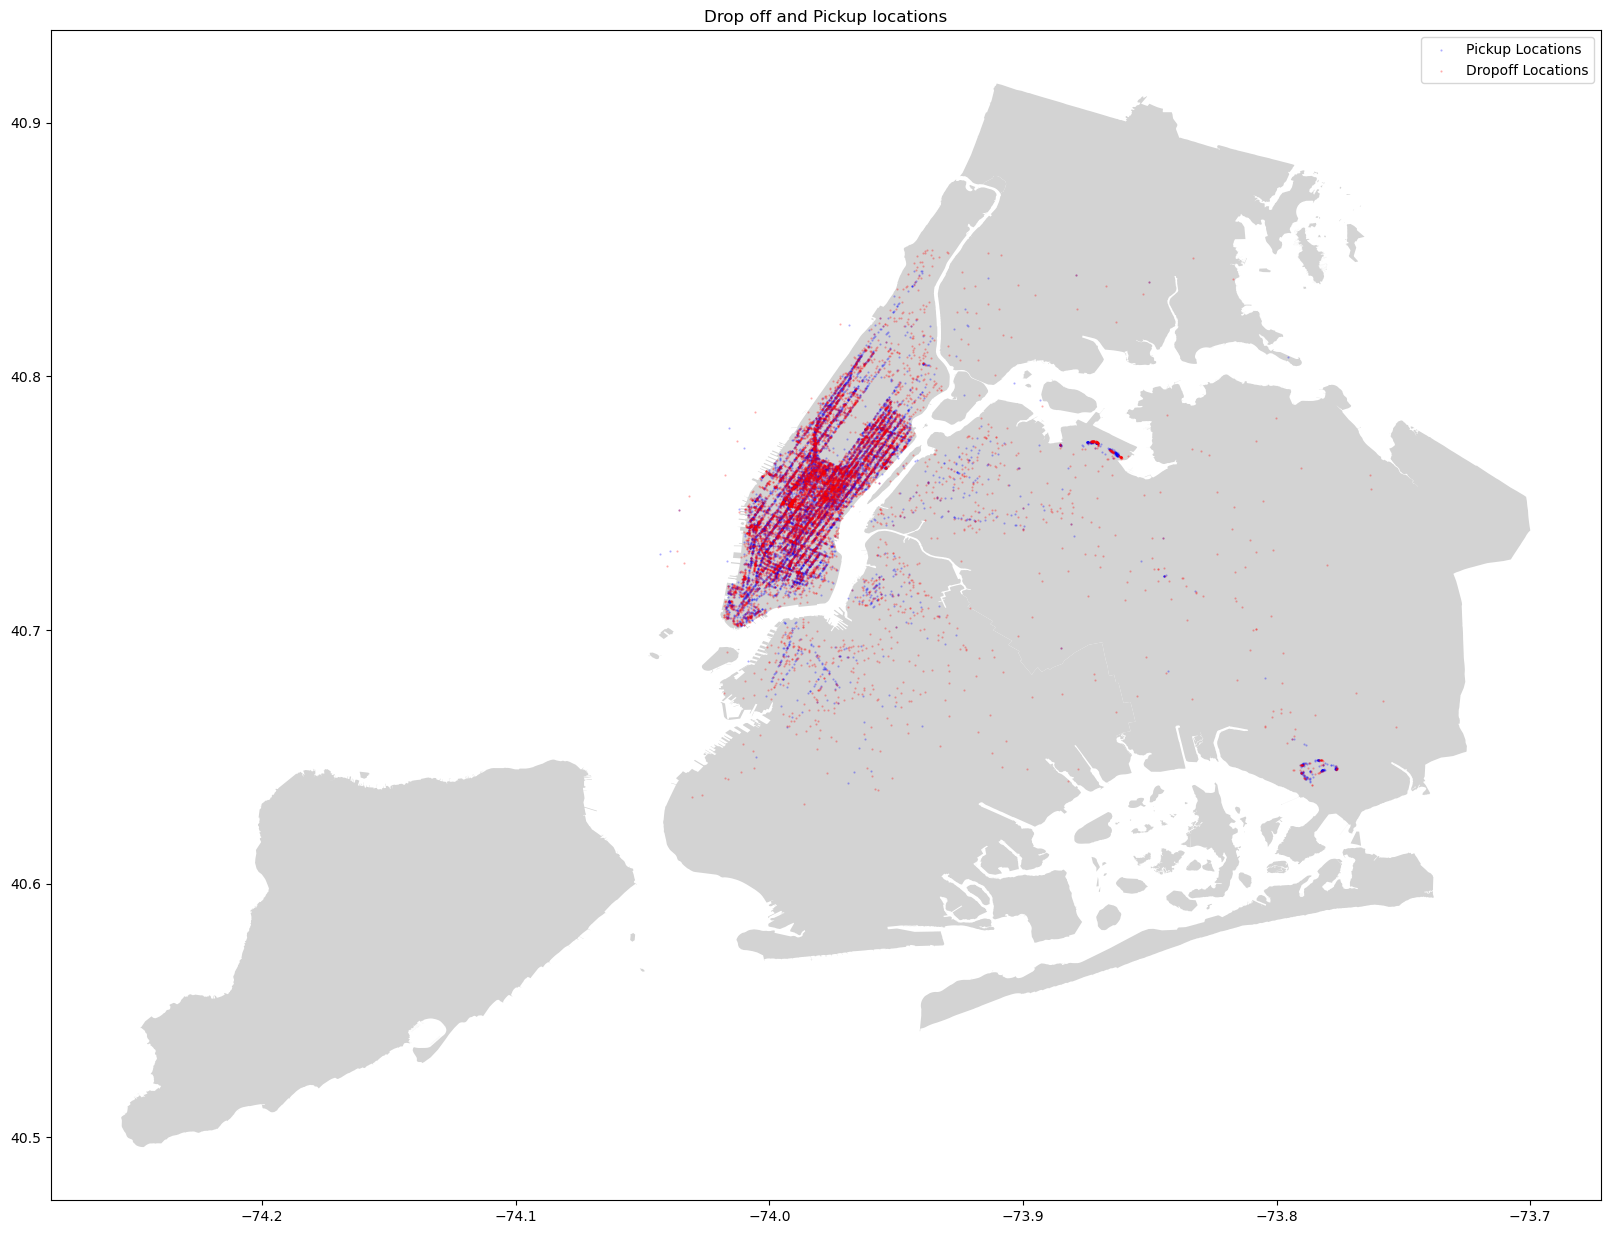

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(20, 20))
nyc_boundary.plot(ax=ax, color='lightgrey')
pickup_gdf.plot(ax=ax, markersize=0.3, color='blue', alpha=0.3, label='Pickup Locations')
dropoff_gdf.plot(ax=ax, markersize=0.3, color='red', alpha=0.3, label='Dropoff Locations')
plt.legend()
plt.title('Drop off and Pickup locations')
plt.show()

<h1> 3. Data Visualization</h1>

### Heatmaps

In [41]:
# Get the coordinates for pickups and dropoffs
pickup_coords = np.array([pickup_gdf.geometry.x, pickup_gdf.geometry.y]).T
dropoff_coords = np.array([dropoff_gdf.geometry.x, dropoff_gdf.geometry.y]).T

C:\Users\manav.000\AppData\Local\Temp\ipykernel_2036\1195024872.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


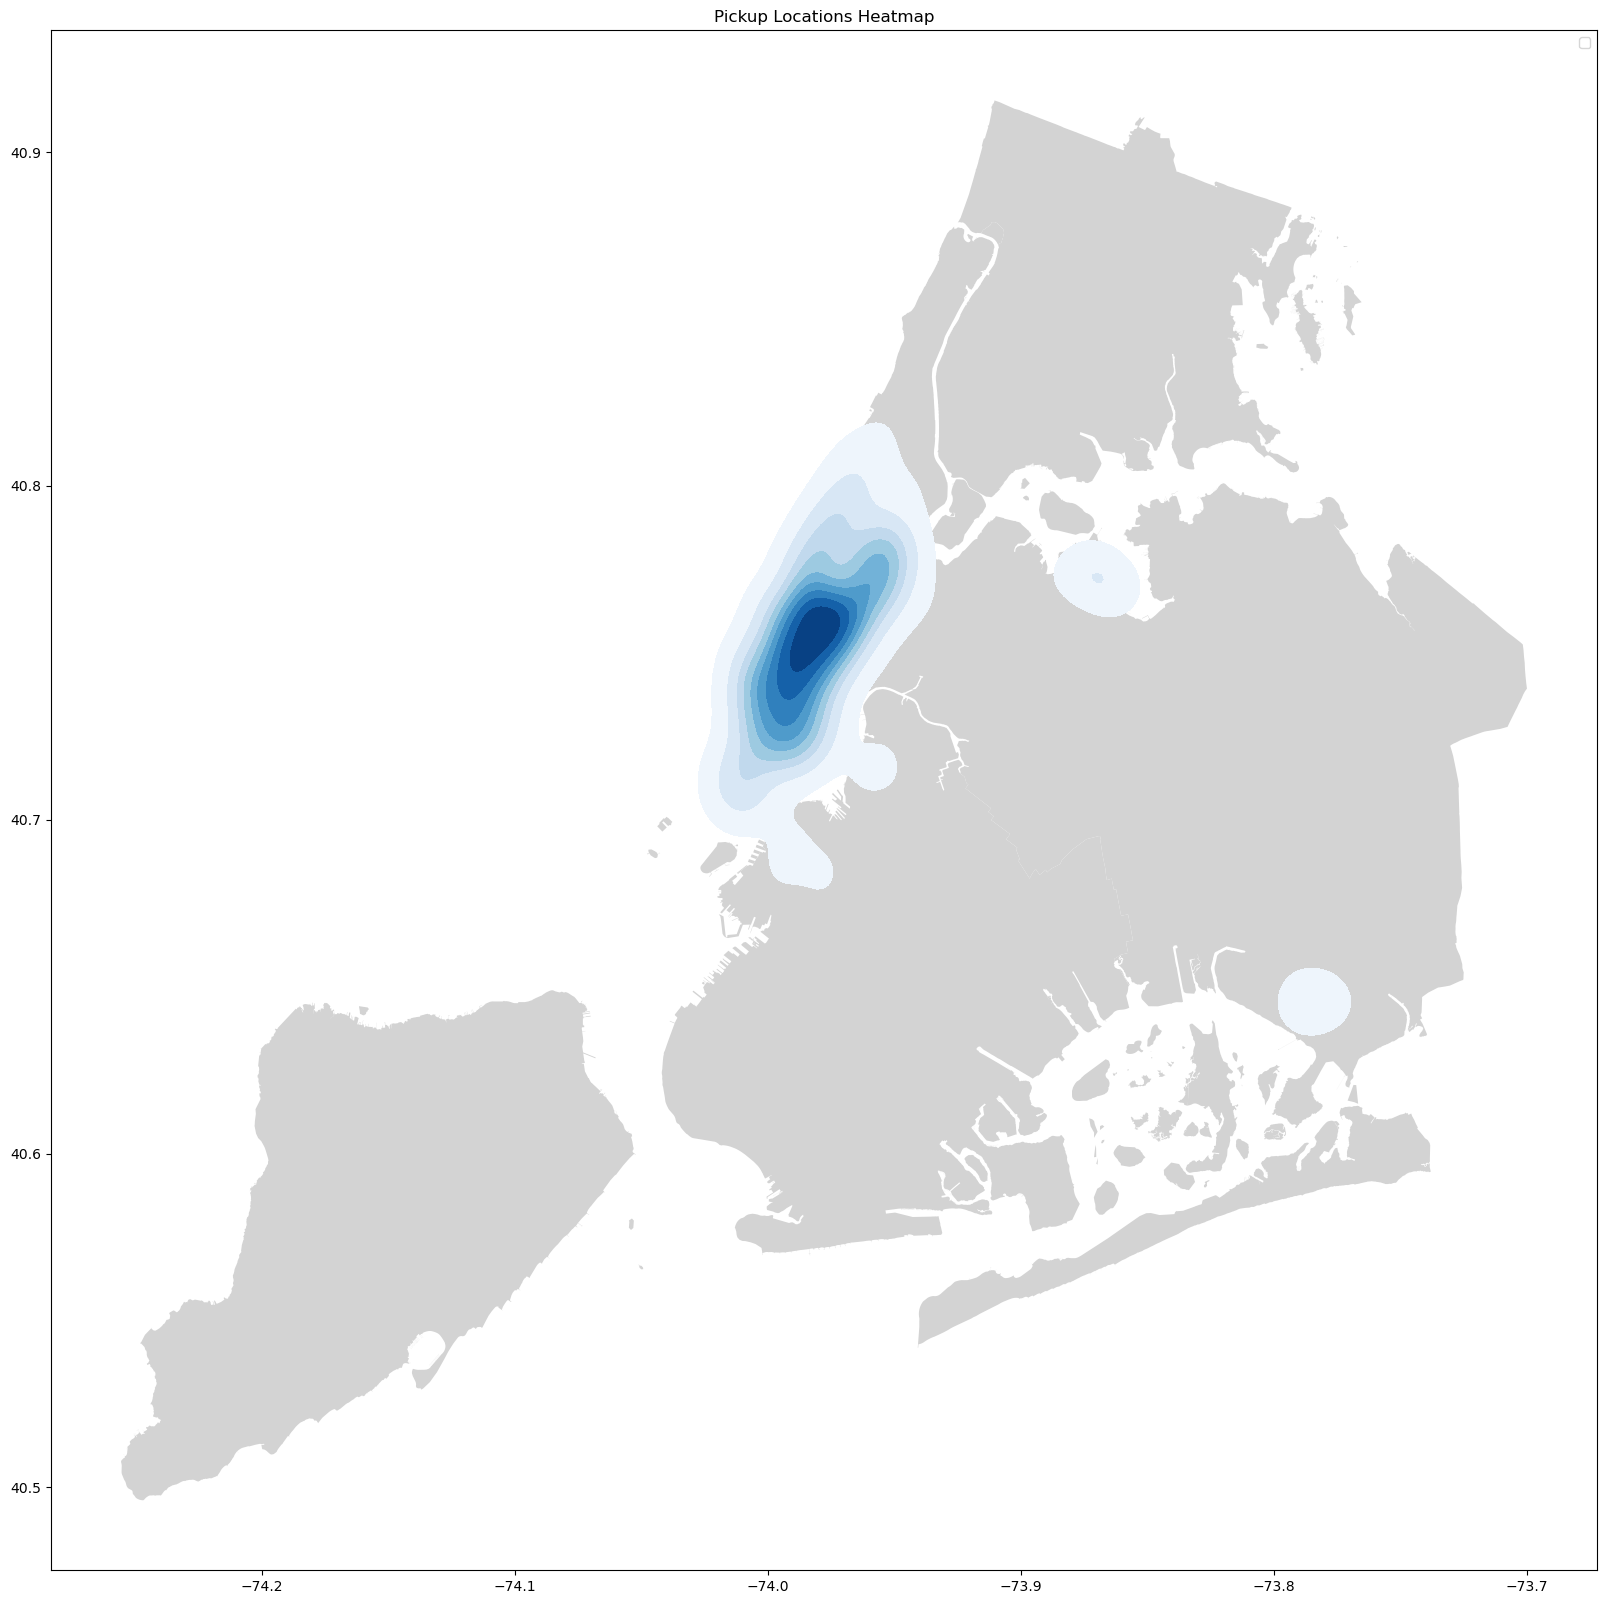

In [42]:
# Plot Pickup Heatmap
fig, ax = plt.subplots(figsize=(20, 20))
nyc_boundary.plot(ax=ax, color='lightgrey')
sns.kdeplot(x=pickup_coords[:, 0], y=pickup_coords[:, 1], ax=ax, cmap='Blues', fill=True, alpha=1, label='Pickup Locations') 
plt.legend()
plt.title('Pickup Locations Heatmap')
plt.show()

C:\Users\manav.000\AppData\Local\Temp\ipykernel_2036\697911166.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


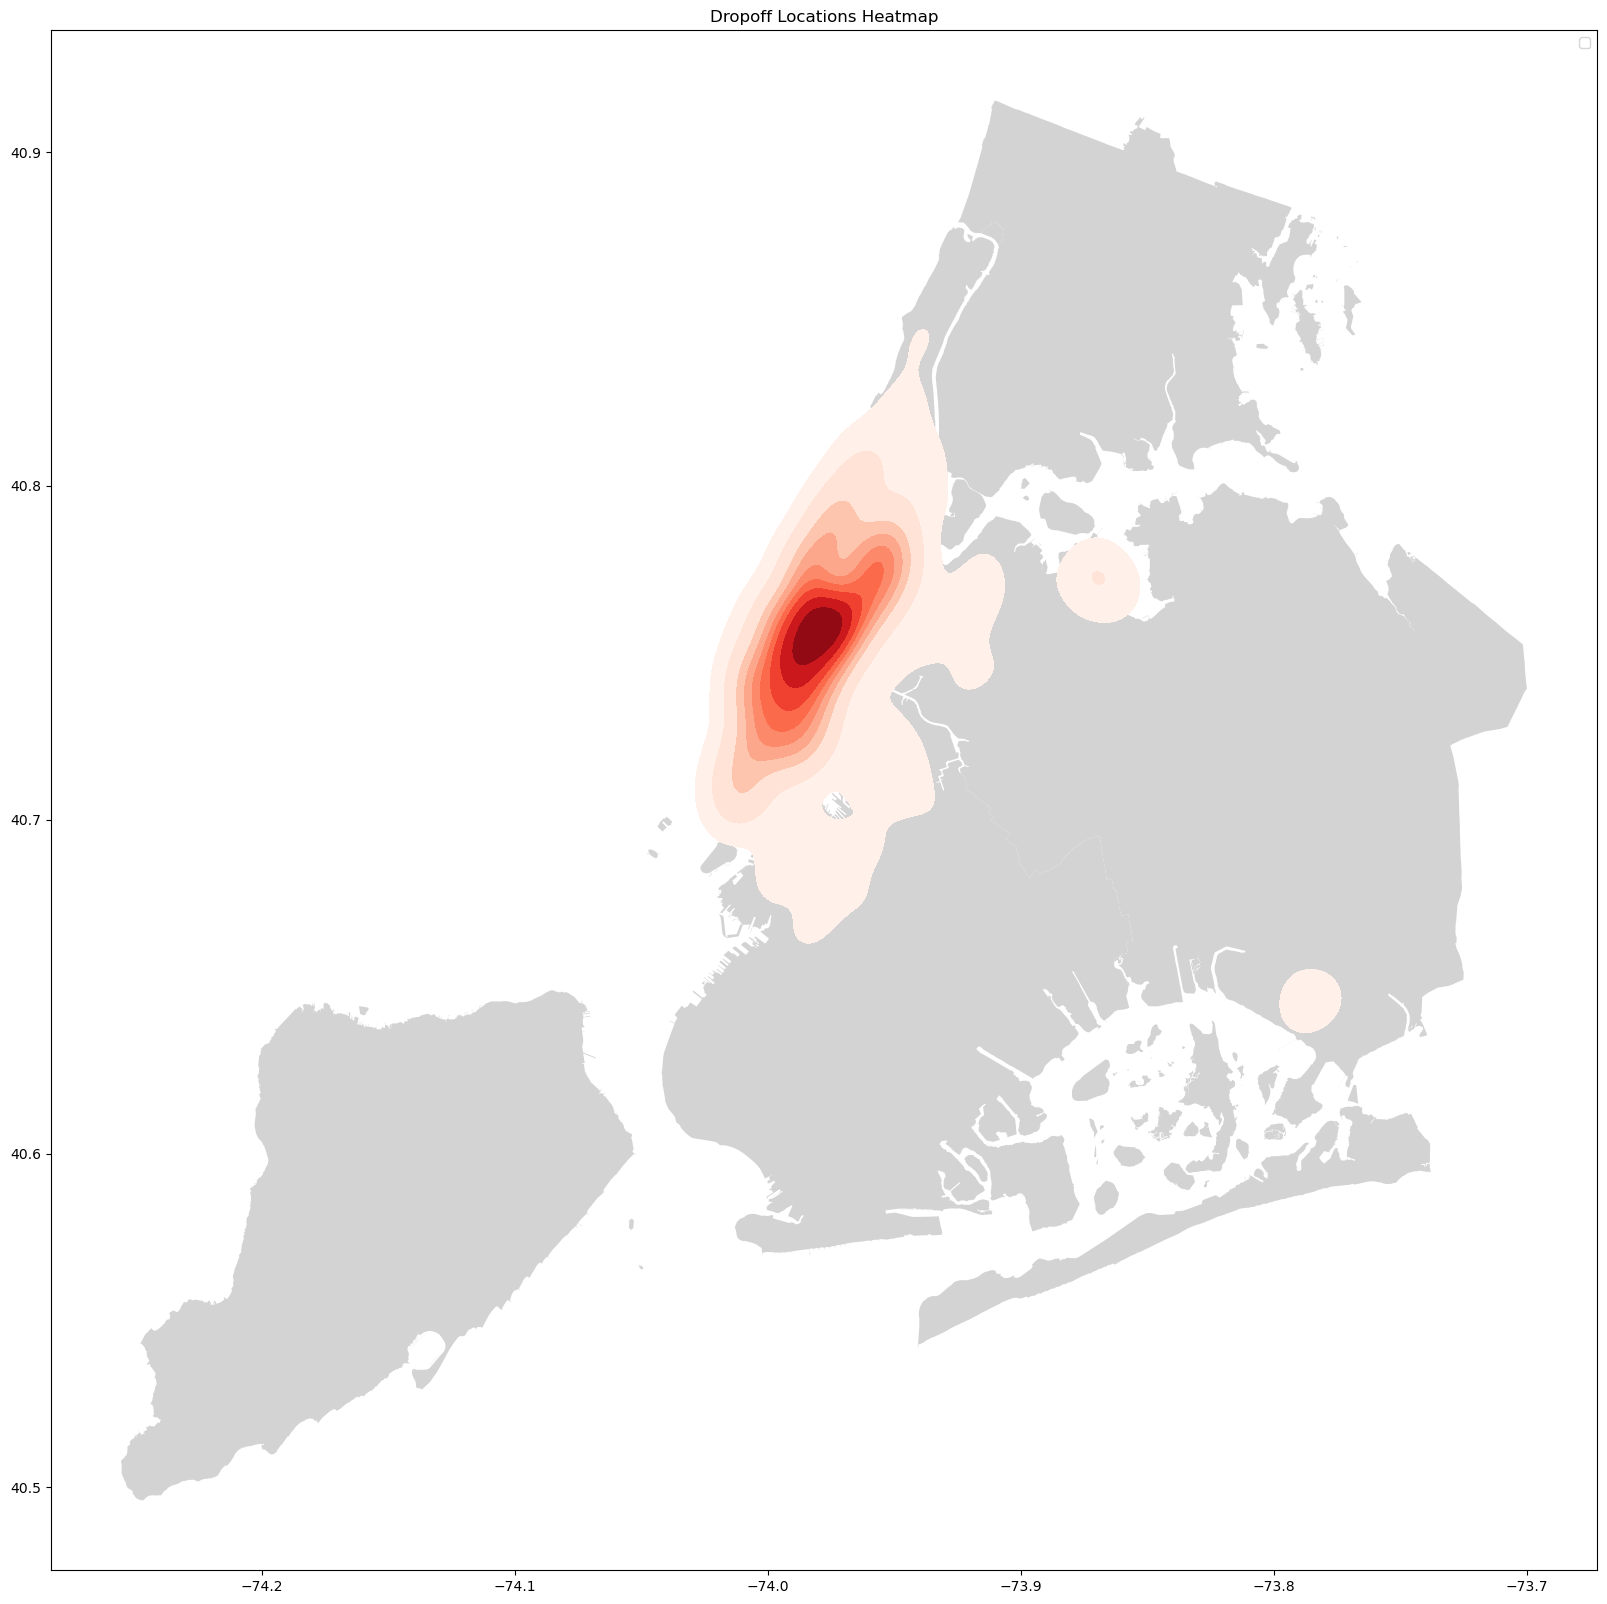

In [43]:
# Plot Dropoff Heatmap
fig, ax = plt.subplots(figsize=(20, 20))
nyc_boundary.plot(ax=ax, color='lightgrey')
sns.kdeplot(x=dropoff_coords[:, 0], y=dropoff_coords[:, 1], ax=ax, cmap='Reds', fill=True, alpha=1, label='Dropoff Locations')
plt.legend()
plt.title('Dropoff Locations Heatmap')
plt.show()

### Fare Distribution by Time of Day

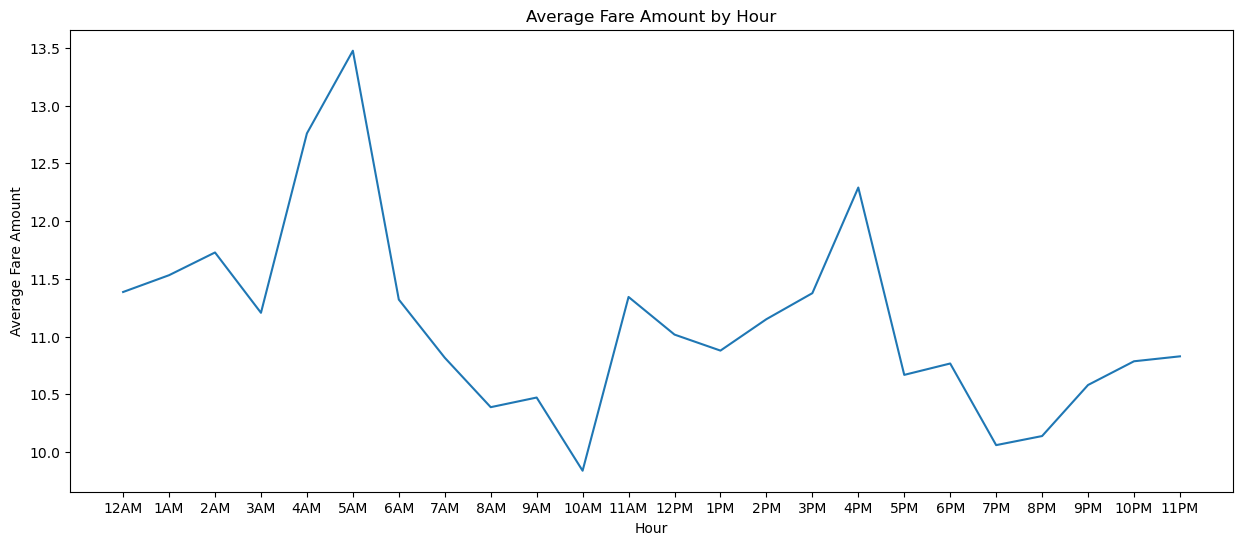

In [60]:
# Group by hour, then get the averages of the fare_amounts for each of the hours
avg_fare = df.groupby('hour')['fare_amount'].mean().reset_index()

# Get labels for 12am to 11pm
hour_labels = [f"{i % 12 or 12}{'AM' if i < 12 else 'PM'}" for i in range(24)]

# Plot this
plt.figure(figsize=(15, 6))
plt.plot(avg_fare['hour'], avg_fare['fare_amount'])
plt.title('Average Fare Amount by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Fare Amount')
plt.xticks(avg_fare['hour'], [hour_labels[i] for i in avg_fare['hour']])
plt.show()

### Distance vs. Fare Scatter Plot

Text(0, 0.5, 'Fare Amount (USD $)')

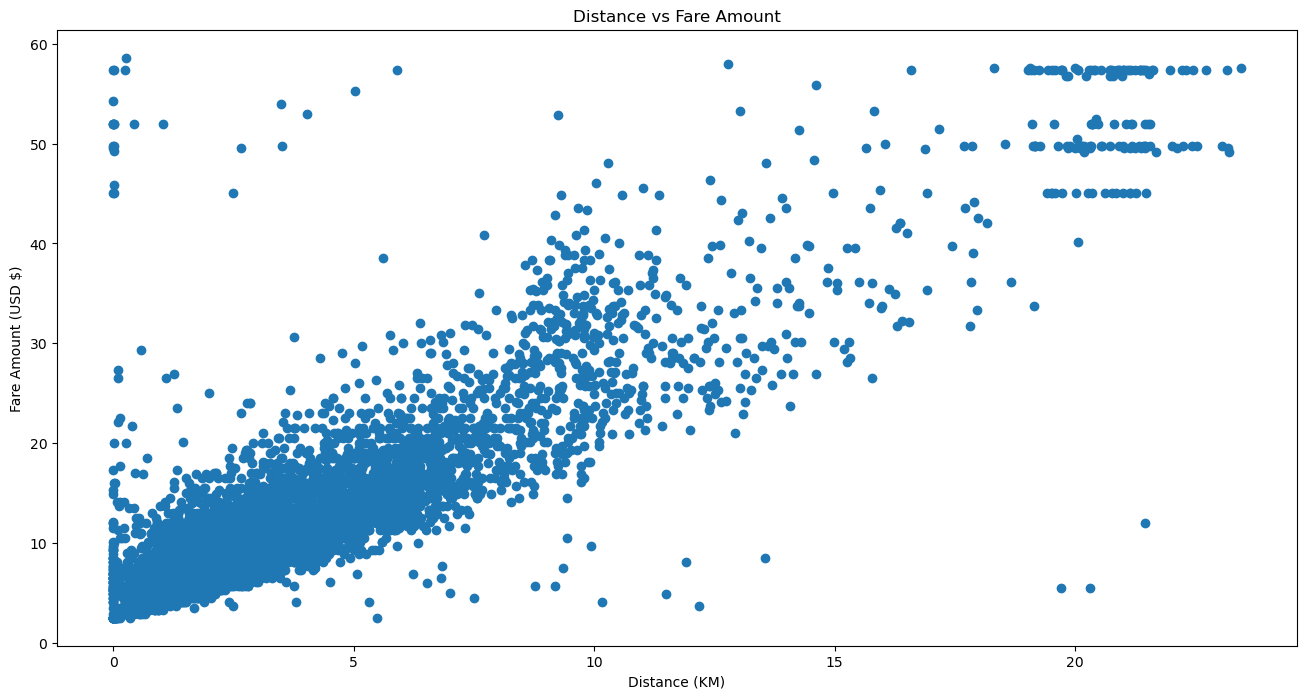

In [67]:
# Plot distance vs fare's
plt.figure(figsize=(16, 8))
plt.scatter(df['distance_km'], df['fare_amount'])
plt.title('Distance vs Fare Amount')
plt.xlabel('Distance (KM)')
plt.ylabel('Fare Amount (USD $)')